In [0]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import math

### build network

In [0]:
def channel_shuffle(x, groups=2):
  bat_size, channels, w, h = x.shape
  group_c = channels // groups
  x = x.view(bat_size, groups, group_c, w, h)
  x = t.transpose(x, 1, 2).contiguous()
  x = x.view(bat_size, -1, w, h)
  return x

# used in the block
def conv_1x1_bn(in_c, out_c, stride=1):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 1, stride, 0, bias=False),
    nn.BatchNorm2d(out_c),
    nn.ReLU(True)
  )

def conv_bn(in_c, out_c, stride=2):
  return nn.Sequential(
    nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False),
    nn.BatchNorm2d(out_c),
    nn.ReLU(True)
  )


class ShuffleBlock(nn.Module):
  def __init__(self, in_c, out_c, downsample=False):
    super(ShuffleBlock, self).__init__()
    self.downsample = downsample
    half_c = out_c // 2
    if downsample:
      self.branch1 = nn.Sequential(
          # 3*3 dw conv, stride = 2
          nn.Conv2d(in_c, in_c, 3, 2, 1, groups=in_c, bias=False),
          nn.BatchNorm2d(in_c),
          # 1*1 pw conv
          nn.Conv2d(in_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )
      
      self.branch2 = nn.Sequential(
          # 1*1 pw conv
          nn.Conv2d(in_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True),
          # 3*3 dw conv, stride = 2
          nn.Conv2d(half_c, half_c, 3, 2, 1, groups=half_c, bias=False),
          nn.BatchNorm2d(half_c),
          # 1*1 pw conv
          nn.Conv2d(half_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )
    else:
      # in_c = out_c
      assert in_c == out_c
        
      self.branch2 = nn.Sequential(
          # 1*1 pw conv
          nn.Conv2d(half_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True),
          # 3*3 dw conv, stride = 1
          nn.Conv2d(half_c, half_c, 3, 1, 1, groups=half_c, bias=False),
          nn.BatchNorm2d(half_c),
          # 1*1 pw conv
          nn.Conv2d(half_c, half_c, 1, 1, 0, bias=False),
          nn.BatchNorm2d(half_c),
          nn.ReLU(True)
      )
      
      
  def forward(self, x):
    out = None
    if self.downsample:
      # if it is downsampling, we don't need to do channel split
      out = t.cat((self.branch1(x), self.branch2(x)), 1)
    else:
      # channel split
      channels = x.shape[1]
      c = channels // 2
      x1 = x[:, :c, :, :]
      x2 = x[:, c:, :, :]
      out = t.cat((x1, self.branch2(x2)), 1)
    return channel_shuffle(out, 2)
    

class ShuffleNet2(nn.Module):
  def __init__(self, num_classes=2, input_size=224, net_type=1):
    super(ShuffleNet2, self).__init__()
    assert input_size % 32 == 0 # 因为一共会下采样32倍
    
    
    self.stage_repeat_num = [4, 8, 4]
    if net_type == 0.5:
      self.out_channels = [3, 24, 48, 96, 192, 1024]
    elif net_type == 1:
      self.out_channels = [3, 24, 116, 232, 464, 1024]
    elif net_type == 1.5:
      self.out_channels = [3, 24, 176, 352, 704, 1024]
    elif net_type == 2:
      self.out_channels = [3, 24, 244, 488, 976, 2948]
    else:
      print("the type is error, you should choose 0.5, 1, 1.5 or 2")
      
    # let's start building layers
    self.conv1 = nn.Conv2d(3, self.out_channels[1], 3, 2, 1)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    in_c = self.out_channels[1]
    
    self.stages = []
    for stage_idx in range(len(self.stage_repeat_num)):
      out_c = self.out_channels[2+stage_idx]
      repeat_num = self.stage_repeat_num[stage_idx]
      for i in range(repeat_num):
        if i == 0:
          self.stages.append(ShuffleBlock(in_c, out_c, downsample=True))
        else:
          self.stages.append(ShuffleBlock(in_c, in_c, downsample=False))
        in_c = out_c
    self.stages = nn.Sequential(*self.stages)
    
    in_c = self.out_channels[-2]
    out_c = self.out_channels[-1]
    self.conv5 = conv_1x1_bn(in_c, out_c, 1)
    self.g_avg_pool = nn.AvgPool2d(kernel_size=(int)(input_size/32)) # 如果输入的是224，则此处为7
    
    # fc layer
    self.fc = nn.Linear(out_c, num_classes)
    

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.stages(x)
    x = self.conv5(x)
    x = self.g_avg_pool(x)
    x = x.view(-1, self.out_channels[-1])
    x = self.fc(x)
    return x
    
    
  
    
    

In [0]:
model = ShuffleNet2()

In [0]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [0]:
model = model.to(device)

### Process data

> You can modify this part to train on your own data.

The train data format

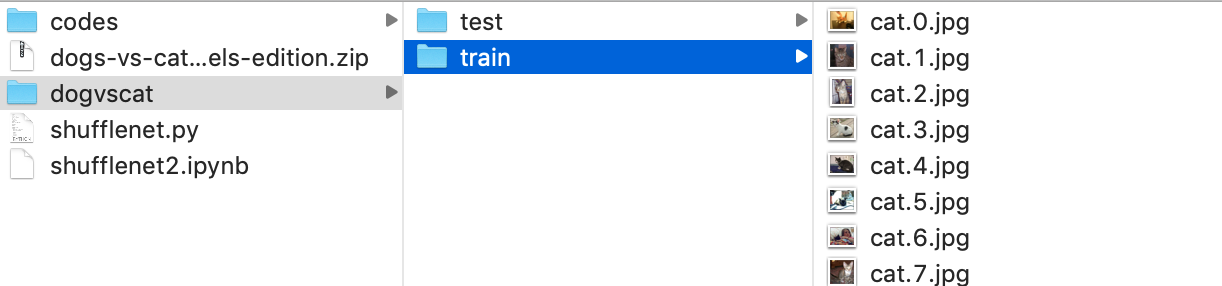

The test data format

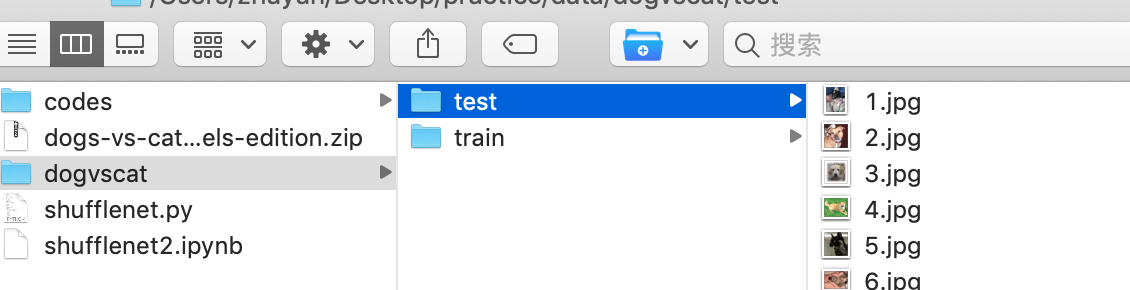

In [0]:
from torchvision import datasets, transforms
import os
import time
from torch.utils import data
import numpy as np
from PIL import Image
import copy

[How to process data using Dataset, Dataloader](https://zhuanlan.zhihu.com/p/30934236)

In [0]:
class DogCat(data.Dataset):
  def __init__(self, root, trans=None, train=True, test=False):
    self.test = test
    self.train = train
    imgs = [os.path.join(root, img) for img in os.listdir(root)]
    '''
    the format of test and trian image name is different
    as for test: /test/102.jpg
    as for train: /train/cat.1.jpg
    '''
    if test: # root: './dogvscat/test/' imgs = ["xx/123.jpg", "xx/234.jpg", ...]
      sorted(imgs, key=lambda x: int(x.split(".")[-2].split("/")[-1])) 
    else:
      sorted(imgs, key=lambda x: int(x.split(".")[-2])) 
    
    # shuffle
    np.random.seed(100)
    imgs = np.random.permutation(imgs)
    
    # split dataset
    if self.test:
      self.imgs = imgs
    elif train:
      self.imgs = imgs[:int(0.7*len(imgs))]
    else:
      self.imgs = imgs[int(0.7*len(imgs)):]
    
    if trans==None:
      normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
      # test and dev dataset do not need to do data augemetation
      if self.test or not self.train:
        self.trans = transforms.Compose([
                                        transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        normalize
                                        ])
      else:
        self.trans = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224), # RandomSizedCrop(224)??
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        normalize
                                        ])
      
 
  def __getitem__(self, index):
    '''
    as for test: just return the id of picture.
    as for train and dev: return 1 if dog, return 0 if cat
    '''
    imgpath = self.imgs[index]
    if self.test:
      label = int(imgpath.split(".")[-2].split("/")[-1])
    else:
      kind = imgpath.split(".")[-3].split("/")[-1]
      label = 1 if kind == "dog" else 0
    img = Image.open(imgpath)
    img = self.trans(img)
    return img, label
  
  def __len__(self):
    return len(self.imgs)

In [0]:
train_dataset = DogCat("./dogvscat/train", train=True)
val_dataset = DogCat("./dogvscat/train", train=False, test=False)
train_loader = data.DataLoader(train_dataset,
                               batch_size = 32,
                               shuffle=True
                               )
val_loader = data.DataLoader(val_dataset,
                             batch_size = 32,
                             shuffle=True)


In [0]:
dataloader = {}
dataloader["train"] = train_loader
dataloader["val"] = val_loader

### training and validating

In [0]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = ShuffleNet2()
model = model.to(device)

In [0]:
loss_fn = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [0]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    val_acc_history = []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                
                with t.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs) # bsize * 2 , because it is a binary classification
                    loss = loss_fn(outputs, labels) 
                
                preds = outputs.argmax(dim=1)
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += t.sum(preds.view(-1) == labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            
            print("Phase {} loss: {}, acc: {}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "val":
                val_acc_history.append(epoch_acc)
    model.load_state_dict(best_model_wts)    
    return model, val_acc_history

In [0]:
model, val_logs = train_model(model, dataloader, loss_fn, optimizer)

### save the best model

In [ ]:
import time
torch.save(model.state_dict(), "./save/" + str(int(time.time()))+'.pkl')